# **Amazon Lookout for Equipment** - 익명화한 익스펜더 데이터셋에 대한 데모
*파트 4: 모델 검증*

## 초기화
---
데이터 준비 노트북을 수행하면 저장소는 이제 다음과 같이 구성됩니다.
```
/lookout-equipment-demo
|
+-- data/
|   |
|   +-- labelled-data/
|   |   \-- labels.csv
|   |
|   \-- training-data/
|       \-- expander/
|           |-- subsystem-01
|           |   \-- subsystem-01.csv
|           |
|           |-- subsystem-02
|           |   \-- subsystem-02.csv
|           |
|           |-- ...
|           |
|           \-- subsystem-24
|               \-- subsystem-24.csv
|
+-- dataset/
|   |-- labels.csv
|   |-- tags_description.csv
|   |-- timeranges.txt
|   \-- timeseries.zip
|
+-- notebooks/
|   |-- 1_data_preparation.ipynb
|   |-- 2_dataset_creation.ipynb
|   |-- 3_model_training.ipynb
|   |-- 4_model_evaluation.ipynb            <<< 본 노트북 <<<
|   \-- 5_inference_scheduling.ipynb
|
+-- utils/
    |-- lookout_equipment_utils.py
    \-- lookoutequipment.json
```

### 임포트

In [1]:
%%sh
pip -q install --upgrade pip
pip -q install --upgrade awscli boto3
aws configure add-model --service-model file://../utils/lookoutequipment.json --service-name lookoutequipment

In [2]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
import boto3
import matplotlib.pyplot as plt
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import sys
import warnings

%load_ext autoreload
%autoreload 2

# Lookout for Equipment API 호출 관리를 위한 Helper 함수
sys.path.append('../utils')
import lookout_equipment_utils as lookout

### 파라미터

In [4]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5

DATA = os.path.join('..', 'data')
LABEL_DATA = os.path.join(DATA, 'labelled-data')
REGION_NAME = boto3.session.Session().region_name

In [5]:
# 기간 범위를 불러옵니다.
timeranges_fname = os.path.join(DATA, 'timeranges.txt')
with open(timeranges_fname, 'r') as f:
    timeranges = f.readlines()
    
training_start   = pd.to_datetime(timeranges[0][:-1])
training_end     = pd.to_datetime(timeranges[1][:-1])
evaluation_start = pd.to_datetime(timeranges[2][:-1])
evaluation_end   = pd.to_datetime(timeranges[3][:-1])

print(f'Training period: from {training_start} to {training_end}')
print(f'Evaluation period: from {evaluation_start} to {evaluation_end}')

Training period: from 2015-01-01 00:00:00 to 2015-08-31 23:59:00
Evaluation period: from 2015-09-01 00:00:00 to 2015-11-30 23:59:00


### 분석 목적으로 원본 데이터셋 불러오기

In [6]:
# 원본 신호 전체를 불러오겠습니다 (나중에 유용합니다).
all_tags_fname = os.path.join(DATA, 'training-data', 'expander.parquet')
table = pq.read_table(all_tags_fname)
all_tags_df = table.to_pandas()
del table

## 모델 검증
---

`DescribeModel` API를 이용하여 훈련시킨 모델과 연관된 측정 항목들을 추출할 수 있습니다. 

In [7]:
MODEL_NAME = 'lookout-demo-model-v1'
lookout_client = lookout.get_client(region_name=REGION_NAME)
describe_model_response = lookout_client.describe_model(ModelName=MODEL_NAME)
list(describe_model_response.keys())

['ModelName',
 'ModelArn',
 'DatasetName',
 'DatasetArn',
 'Schema',
 'LabelsInputConfiguration',
 'TrainingDataStartTime',
 'TrainingDataEndTime',
 'EvaluationDataStartTime',
 'EvaluationDataEndTime',
 'RoleArn',
 'DataPreProcessingConfiguration',
 'Status',
 'TrainingExecutionStartTime',
 'TrainingExecutionEndTime',
 'ModelMetrics',
 'LastUpdatedTime',
 'CreatedAt',
 'ResponseMetadata']

모델 설명은 Dictionary로 응답 받습니다. `labeled_ranges`에는 입력으로 제공된 라벨이 포함되고 `predicted_ranges`에는 Lookout for Equipment가 이상을 감지한 예측 범위 전체가 포함됩니다. 다음의 유틸리티 함수를 사용하여 두 개의 Dataframe으로 가져옵니다. 

In [8]:
LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=all_tags_df, region_name=REGION_NAME)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

**참고:** 모델 설명 API는 라벨이 지정된 범위로 검증 범위에 속하는 라벨 데이터만 제공합니다. 전 기간을 얻기 위해서는 라벨 원본 데이터를 사용해야 합니다.

이제 원본 신호 중 하나를 시각화한 후 라벨이 지정된 범위와 예측한 범위를 동일 플롯에 매핑해보겠습니다. 

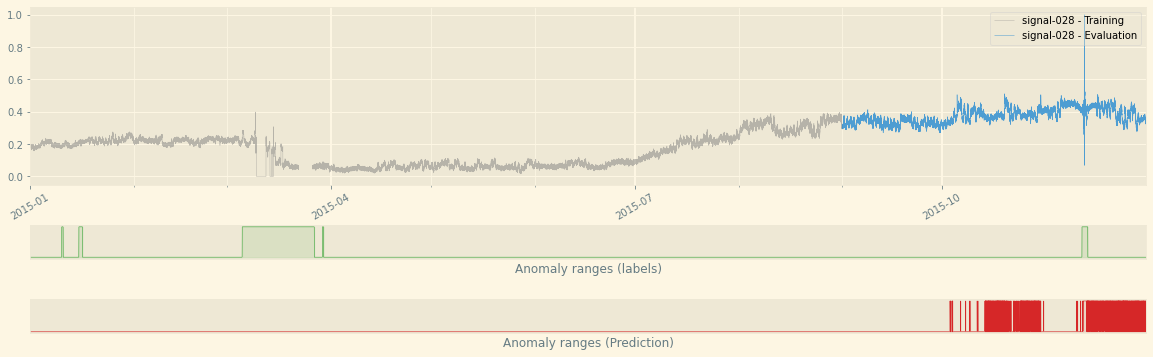

In [9]:
# 데이터 준비 단계에서 살펴본 원본 신호를 불러옵니다.
tag = 'signal-028'
tag_df = all_tags_df.loc[training_start:evaluation_end, [tag]]
tag_df.columns = ['Value']

# 전 기간을 그려봅니다.
fig, axes = lookout.plot_timeseries(
    timeseries_df=tag_df, 
    tag_name=tag,
    fig_width=20, 
    tag_split=evaluation_start, 
    labels_df=labeled_range,
    predictions=predicted_ranges
)

## 진단
---

비교해봅시다.
1. **검증 기간**에 **이상**으로 표시된 기간 내의 신호 값
2. **훈련 기간**에 정상으로 간주된 신호 값

각 신호마다 **두 개의 히스토그램을 그려봅니다.** 하나는 이상 징후로 표시된 포인트들에 대해서 빨간색으로 표시하고 다른 모든 일반 데이터 포인트들에 대해서는 녹색으로 표시합니다. 또한 이 두 분포 사이의 거리를 계산하여 내림차순으로 순위를 매깁니다. 비교 이유는 모델를 통해 이상 징후를 표시할 때 어떤 신호가 정상 동작과 가장 많이 다른지 보여주기 위함입니다. 이러한 내용을 통해 고객 SME가 이상 발생 원인을 조사할 수 있도록 올바른 방향을 제시합니다.

Preparing histograms: 100%|██████████| 12/12 [00:00<00:00, 13.45it/s]


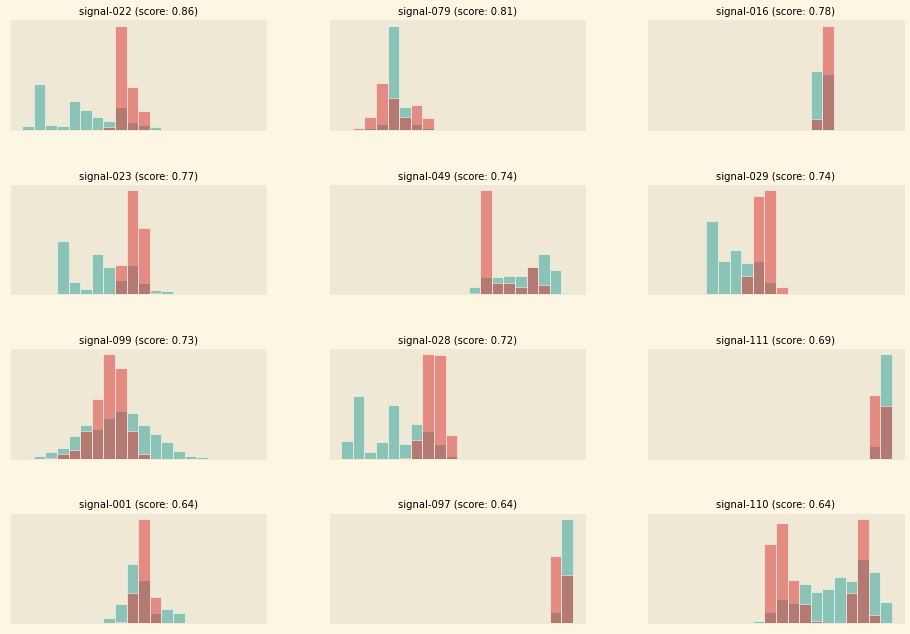

In [10]:
LookoutDiagnostics.compute_histograms()
_ = LookoutDiagnostics.plot_histograms()

또한 각 시계열 신호마다 이상으로 표시된 데이터 포인트를 직접 그려볼 수 있습니다.
* **녹색**, 훈련과 검증 기간 동안의 정상 값
* **빨간색**, 훈련한 모델에서 이상 징후로 예측한 값
* **회색**으로 표시된 값은 정상 조건에서 작동할 때의 설비 동작을 잡아내기 위해서 훈련에서 제외되어 이상으로 표시됩니다.

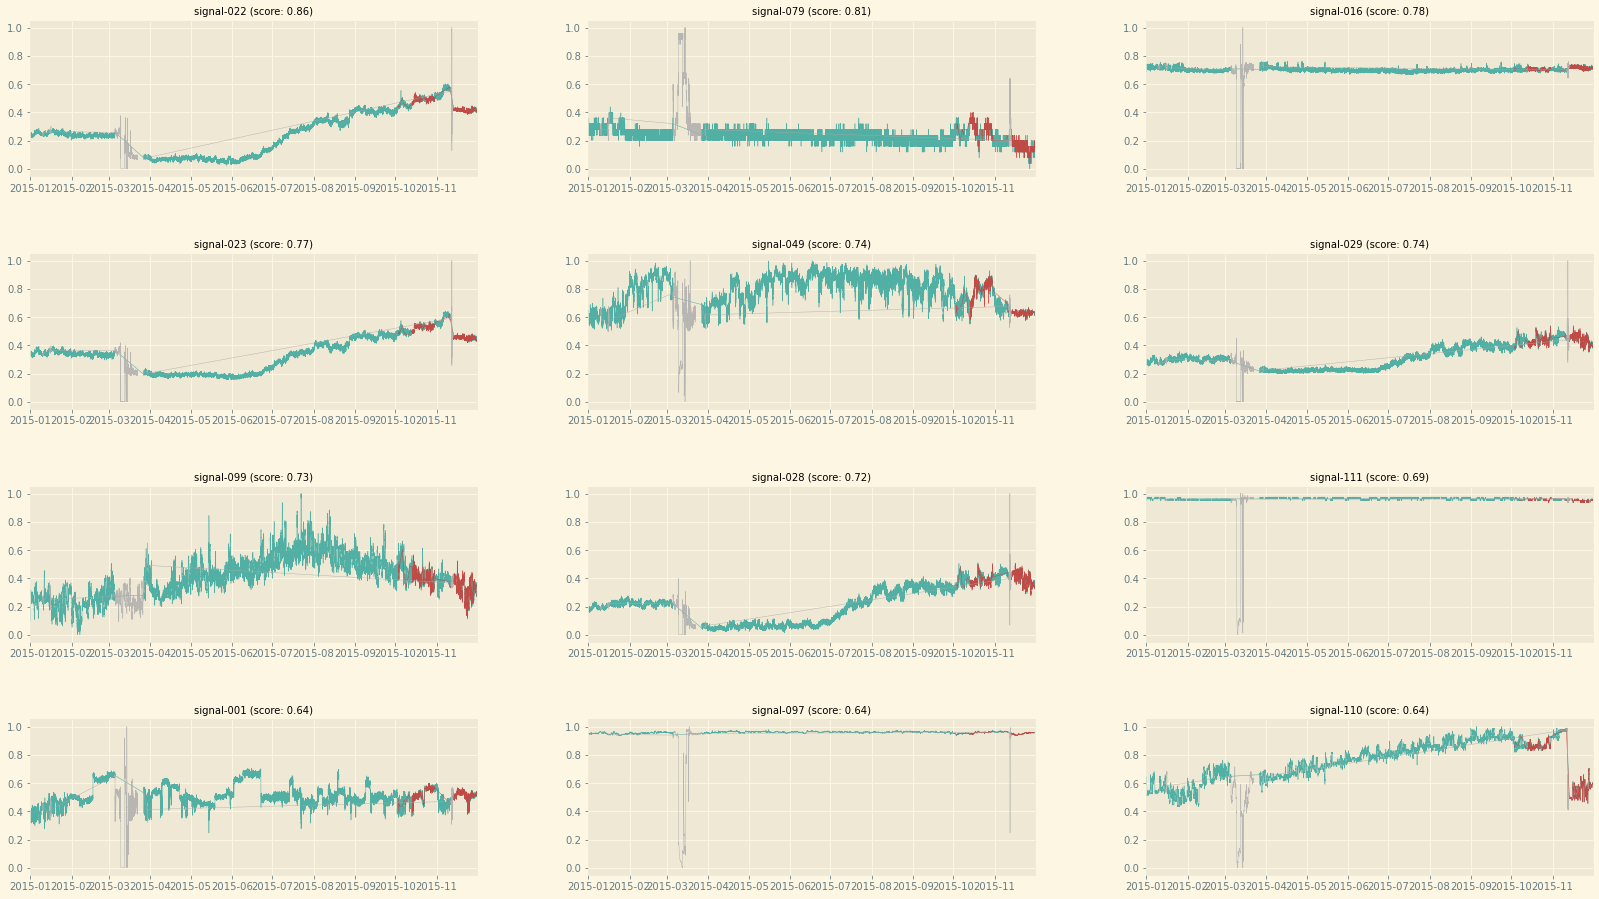

In [11]:
_ = LookoutDiagnostics.plot_signals()

이제 위 신호들의 List를 추출해보겠습니다.

In [12]:
LookoutDiagnostics.get_ranked_list()

,Tag,Rank
0,signal-022,0.862343
1,signal-079,0.805001
2,signal-016,0.776623
3,signal-023,0.768863
4,signal-049,0.744106
5,signal-029,0.741041
6,signal-099,0.725389
7,signal-028,0.718070
8,signal-111,0.685265
9,signal-001,0.643934


## 결론
---
이 노트북에서는 노트북 시리즈 파트 3에서 만든 모델을 사용하여 얻은 결과에 대해 몇 가지 시각화와 진단을 수행했습니다. 이제 모델을 구동하여 신규 데이터를 제공하고 결과를 저장할 다음 단계, 즉 **추론 스케줄링 노트북**으로 이동할 수 있습니다.